In [45]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

# Data wrangling

In [35]:
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'fire_name','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df

,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2/11/2007,Feb,1/12/2007,2007,...,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,3.0,B,Arson,35.038330,-87.610000,TN,12/11/2006,Dec,11/11/2006,2006,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,60.0,C,Arson,34.947800,-88.722500,MS,2/29/2004,Feb,1/30/2004,2004,...,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,1.0,B,Debris Burning,39.641400,-119.308300,NV,6/6/2005,Jun,5/7/2005,2005,...,0.000000,44.778429,37.140811,35.353846,0.000000,10.4,7.2,0.0,0.0,0.487447
4,2.0,B,Miscellaneous,30.700600,-90.591400,LA,9/22/1999,Sep,8/23/1999,1999,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.214633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55362,6289.0,G,Missing/Undefined,39.180000,-96.784167,KS,10/15/2015,Oct,9/15/2015,2015,...,3.804803,65.671410,61.839572,54.625698,55.042092,35.4,8.2,0.0,249.0,0.331501
55363,70868.0,G,Missing/Undefined,38.342719,-120.695967,CA,9/9/2015,Sep,8/10/2015,2015,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.124683
55364,5702.0,G,Arson,37.262607,-119.511139,CA,7/25/2015,Jul,6/25/2015,2015,...,2.529158,43.755556,43.755556,44.443975,35.924406,0.0,0.0,0.0,0.0,0.097682
55365,3261.0,F,Miscellaneous,40.604300,-123.080450,CA,7/31/2015,Jul,7/1/2015,2015,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.0,0.178206


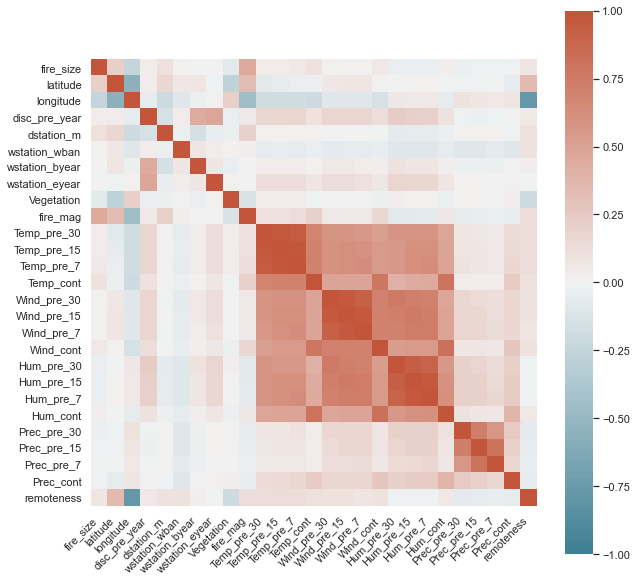

In [36]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(10,10)})

55367
41132


<AxesSubplot:>

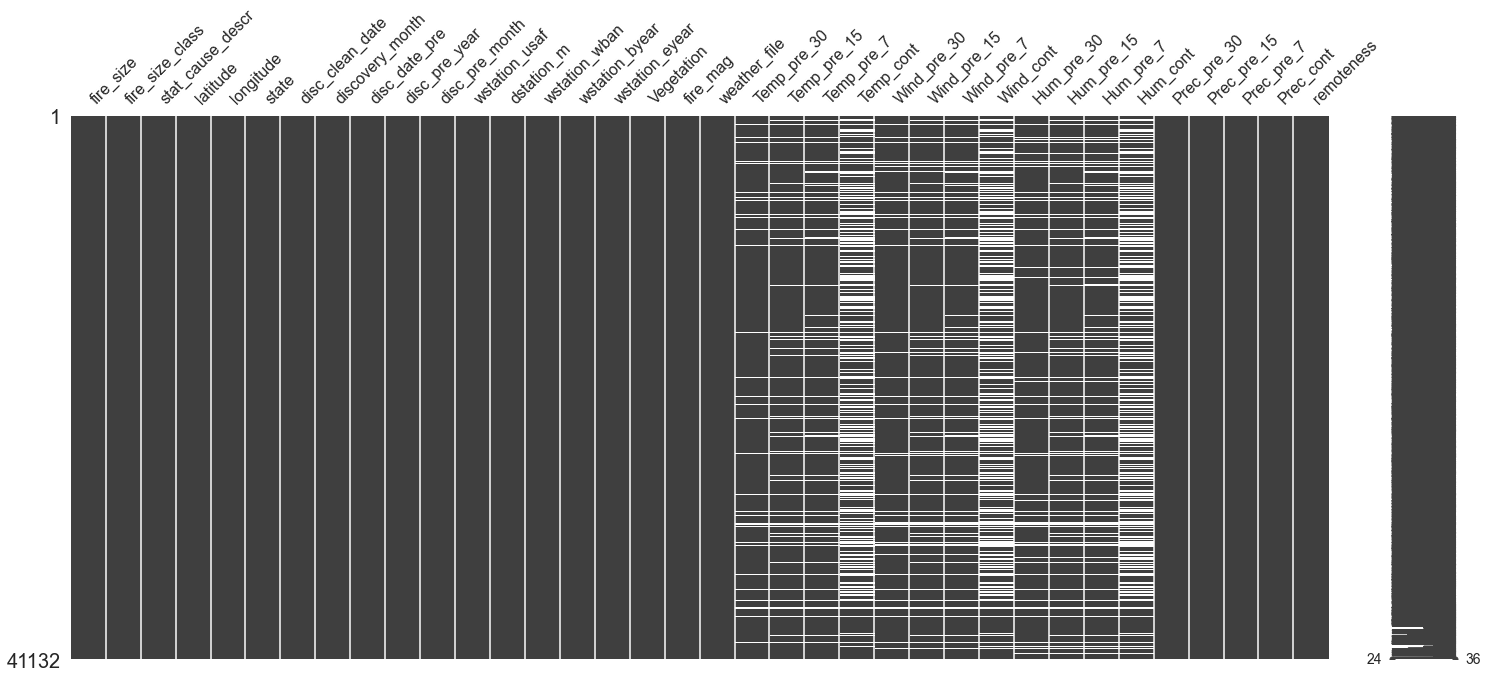

In [37]:
### Dealing with missing data
print(len(df))

# drop columns where weather file is missing
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

# Weather data has a lot of 0 values some of which may be missing values
# So here we mark '0' values in weather columns as Na (to see how many there are)
subset = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset] = df[subset].replace({0:np.nan, '0':np.nan})
subset_neg1 = ['Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

msno.matrix(df)


In [38]:
# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont'])
print(len(df))
# This leaves us with 38,689 observations to work with (originally we had 50,000)

# fill pre columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill nas of current based on mean values from previous days
df['Temp_cont'] = df.apply(
    lambda row: (row['Temp_pre_7']+row['Temp_pre_15']+row['Temp_pre_30'])/3 if np.isnan(row['Temp_cont']) else row['Temp_cont'],
    axis=1)

df['Wind_cont'] = df.apply(
    lambda row: (row['Wind_pre_7']+row['Wind_pre_15']+row['Wind_pre_30'])/3 if np.isnan(row['Wind_cont']) else row['Wind_cont'],
    axis=1)

df['Hum_cont'] = df.apply(
    lambda row: (row['Hum_pre_7']+row['Hum_pre_15']+row['Hum_pre_30'])/3 if np.isnan(row['Hum_cont']) else row['Hum_cont'],
    axis=1)

38689


/Users/janmagnuszewski/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
<ipython-input-38-2b6be1dd6e41>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temp_cont'] = df.apply(
<ipython-input-38-2b6be1dd6e41>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [39]:
from datetime import datetime
import matplotlib.pyplot as plt

In [40]:
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')
df.head(4)

<ipython-input-40-355446f833f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')


,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,...,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness
0,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2007-02-11,Feb,1/12/2007,2007,...,3.250413,78.216590,76.793750,76.381579,78.724370,0.0,0.0,0.0,0.0,0.017923
1,3.0,B,Arson,35.038330,-87.610000,TN,2006-12-11,Dec,11/11/2006,2006,...,2.122320,70.840000,65.858911,55.505882,81.682678,59.8,8.4,0.0,86.8,0.184355
2,60.0,C,Arson,34.947800,-88.722500,MS,2004-02-29,Feb,1/30/2004,2004,...,3.369050,75.531629,75.868613,76.812834,65.063800,168.8,42.2,18.1,124.5,0.194544
3,1.0,B,Debris Burning,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,...,3.708198,44.778429,37.140811,35.353846,39.091029,10.4,7.2,0.0,0.0,0.487447


In [41]:
#one hot encoding vegetation
df['Vegetation'] = df['Vegetation'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df.head()

<ipython-input-41-7d0d2ed17201>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Vegetation'] = df['Vegetation'].astype('category')


,fire_size,fire_size_class,stat_cause_descr,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,...,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16
0,10.0,C,Missing/Undefined,18.105072,-66.753044,PR,2007-02-11,Feb,1/12/2007,2007,...,0.0,0.0,0.0,0.017923,0,0,1,0,0,0
1,3.0,B,Arson,35.038330,-87.610000,TN,2006-12-11,Dec,11/11/2006,2006,...,8.4,0.0,86.8,0.184355,0,0,0,0,1,0
2,60.0,C,Arson,34.947800,-88.722500,MS,2004-02-29,Feb,1/30/2004,2004,...,42.2,18.1,124.5,0.194544,0,0,0,0,0,1
3,1.0,B,Debris Burning,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,...,7.2,0.0,0.0,0.487447,0,0,0,0,0,0
6,5.2,B,Debris Burning,31.316978,-83.393649,GA,2009-01-10,Jan,12/11/2008,2008,...,0.0,0.0,0.0,0.148904,0,0,1,0,0,0


In [42]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']]
y = df['fire_size']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

X_norm = (X-X.min())/(X.max()-X.min())
y_norm = (y-y.min())/(y.max()-y.min())

## Modelling

In [43]:
# Deccision trees
# Random forest
# PCA
# neural network
# XGboost

In [46]:
# Deccision trees
dectr = DecisionTreeRegressor(random_state=0)
cross_val_score(dectr, X_train, y_train, cv=10)


array([-0.6033693 , -2.80414998, -0.90042443, -0.73509633, -0.34882019,
       -2.29190524, -0.1106011 , -2.05396735, -0.54797085, -0.28415803])

## Other

In [ ]:
# Get weather stations ordered by distance to Vancouver, BC
stations = Stations(lat = 38.843988, lon = -122.759707, daily = datetime(2018, 1, 1))
# Fetch closest station (limit = 1)
station = stations.fetch(1)

data = Daily(station, start = datetime(2018, 1, 1), end = datetime(2018, 1, 1))
# Fetch Pandas DataFrame
data = data.fetch()

data.plot(y=['tavg', 'tmin', 'tmax'])